# Comp methods of many body physics HW1

## Nativ Maor 319002911

In [2]:
using SparseArrays, LinearAlgebra, Arpack, LsqFit

In [3]:
using PyPlot

Auxiliary functions

In [4]:
function FlipSpins(x,i,j)
    f = typeof(x)(1)<<(i-1) | typeof(x)(1)<<(j-1) 
    return x ⊻ f
end

FlipSpins (generic function with 1 method)

The Hamiltonian from the recitation to compare ground state with

In [5]:
function ConstructHeisenbergHamiltonian(N)
    
    H = spzeros(2^N,2^N) # sparse matrix, will actually store only non-zero values, 
                         # i.e. no storage is allocated upon construction

    # Iterate over all the states in the basis |a> and calculate the nonzero matrix elements <b|H|a>
    # Recall that H = \sum_i H_{i,i+1}
    for a in range(0, length = 2^N)
        for i in range(1, length = N)
            j = mod(i,N)+1 # periodic boundary conditions
            si = ( a & 1<<(i-1) ) >> (i-1)
            sj = ( a & 1<<(j-1) ) >> (j-1)

            if si == sj
                H[a+1,a+1] += 1/4 # indexing in Julia is 1-based !!!
            else
                H[a+1,a+1] += - 1/4
                b = FlipSpins(a,i,j)
                H[a+1,b+1] = 1/2
            end
        end
    end
    
    return H
end

ConstructHeisenbergHamiltonian (generic function with 1 method)

# (0) warmup

Using:
$$
H=J\sum_{\langle ij \rangle} \vec{S_i}\cdot \vec{S_j} = J\sum_{\langle ij \rangle} [S_i^z S_j^z+1/2(S_i^+S_j^-+ S_i^-S_j^+)]
$$

In [6]:
function Hψ(ψ,J=1,shift=0)
    D=length(ψ)
    N_qubits=UInt(log2(D))
    new_ψ=zeros(D)
    for a in range(0,length=D)
        for j in range(1,length= N_qubits)
            j′= j%N_qubits+1
            sj = ( a & 1<<(j-1) ) >> (j-1)
            sj′= ( a & 1<<(j′-1) ) >> (j′-1)
            if sj==sj′
                new_ψ[a+1]+=J*ψ[a+1]/4
            else
                new_ψ[a+1]-=J*ψ[a+1]/4
                a_flipped=FlipSpins(a,j,j′)
                new_ψ[a_flipped+1]+=ψ[a+1]*J/2
            end
        end
    end
    return new_ψ+shift*ψ
end

Hψ (generic function with 3 methods)

In [7]:
function ψHψ(ψ,J=1,shift=0)
    H_ψ=Hψ(ψ,J,shift)
    return ψ⋅H_ψ/(ψ⋅ψ)
end

ψHψ (generic function with 3 methods)

In [73]:
function Hψ(ψ,J=1)
    D=length(ψ)
    N_qubits=UInt(log2(D))
    new_ψ=zeros(D)
    for a in range(0,length=D)
        for j in range(1,length= N_qubits)
            j′= j%N_qubits+1
            sj = ( a & 1<<(j-1) ) >> (j-1)
            sj′= ( a & 1<<(j′-1) ) >> (j′-1)
            if sj==sj′
                new_ψ[a+1]+=J*ψ[a+1]/4
            else
                new_ψ[a+1]-=J*ψ[a+1]/4
                a_flipped=FlipSpins(a,j,j′)
                new_ψ[a_flipped+1]+=ψ[a+1]*J/2
            end
        end
    end
    return new_ψ
end

Hψ (generic function with 3 methods)

In [8]:
function normalize_state!(ψ)
    ψ./=sqrt(sum(ψ.^2))
end

normalize_state! (generic function with 1 method)

In [8]:
iterations=100
N=12
ψ_arr=Vector{Vector{Any}}()
random_ψ=rand(2^N)
normalize!(random_ψ)
push!(ψ_arr,random_ψ)
for i in range(1,iterations)
    new_ψ=Hψ(last(ψ_arr))
    normalize!(new_ψ)
    push!(ψ_arr,new_ψ)
end

In [9]:
ground_energy_arr=Vector{Any}()
for vec in ψ_arr
    push!(ground_energy_arr,ψHψ(vec))
end

# Using the hamiltonian from the recitations to compare ground energy with

In [10]:
H = ConstructHeisenbergHamiltonian(N);

In [11]:
En = eigvals(Matrix(H));
En_sorted=sort(En)
println("Ground state energy is ", En_sorted[1])

Ground state energy is -5.387390917445211


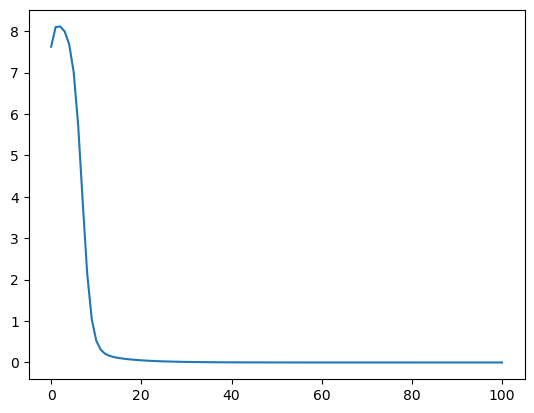

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3388a59510>

In [12]:
plot(ground_energy_arr.-En[1])

The ground state converges to 0 with the increase of iterations.

# (1)

In [9]:
struct FixedSzBasis
    N::Int64
    Nup::Int64
    states::Vector{Int64}
    
    function FixedSzBasis(N::Int, Nup::Int)

        Ndown = N - Nup

        D = binomial(N, Nup)
        
        println("Dimension of subspace with S^z=", (Nup-Ndown)/2, " is ", D)

        states = zeros(Int, D)

        k=1
        for a in range(0, length = 2^N) # loop over all basis states
            if count_ones(a) == Nup
                states[k] = a
                k += 1
            end
        end
        
        new(N, Nup, states)
    end
    
end

import Base.length
function length(b::FixedSzBasis)
    return length(b.states)
end

function Sz(b::FixedSzBasis)
    Ndown = b.N - b.Nup
    return (b.Nup-Ndown)/2
end

Sz (generic function with 1 method)

In [10]:
function ConstructHeisenbergHamiltonian_generalized(basis::FixedSzBasis,J=1,couple_distance=1)
    
    D = length(basis)
    
    H = spzeros(D,D)
    
    # Iterate over all the states in the basis |a> and calculate the nonzero matrix elements <b|H|a>
    # Recall that H = \sum_i H_{i,i+1}
    for k in range(1, length = D)
        
        a = basis.states[k]

        for i in range(1, length = basis.N)
            j = mod(i-1+couple_distance,basis.N)+1 # periodic boundary conditions
            si = ( a & 1<<(i-1) ) >> (i-1)
            sj = ( a & 1<<(j-1) ) >> (j-1)

            if si == sj
                H[k,k] += J/4
            else
                H[k,k] += - J/4
                b = FlipSpins(a,i,j)
                l = searchsortedfirst(basis.states,b)
                @assert (l<=D) && (basis.states[l] == b) "Invalid basis state generated by FlipSpins"
                H[k,l] = J/2
            end
        end
    end
    
    return H
end

ConstructHeisenbergHamiltonian_generalized (generic function with 3 methods)

In [11]:
function generelized_hamiltonian_given_J1_J2_and_fixed_Sz_basis(J1,J2,Sz_basis)
    H1=ConstructHeisenbergHamiltonian_generalized(Sz_basis,J1,1)
    H2=ConstructHeisenbergHamiltonian_generalized(Sz_basis,J2,2)
    return H1+H2
end

generelized_hamiltonian_given_J1_J2_and_fixed_Sz_basis (generic function with 1 method)

In [19]:
using Plots

In [26]:
N, Nup = 10,5
basis = FixedSzBasis(N,Nup);
J1=0
J2=1
@time H = generelized_hamiltonian_given_J1_J2_and_fixed_Sz_basis(J1,J2,basis);

Dimension of subspace with S^z=0.0 is 252
  0.000559 seconds (24 allocations: 140.516 KiB)


In [27]:
@time res = eigs(H; nev=10, which=:LM, ritzvec=false) # Using Lanczos to calculate lowest eigenvalues!
En = res[1]
En_sorted=sort(res[1])

  0.004350 seconds (2.06 k allocations: 129.484 KiB)


10-element Vector{Float64}:
 -3.736067977499794
 -3.7360679774997916
 -3.736067977499791
 -3.7360679774997907
 -3.73606797749979
 -3.7360679774997885
 -3.7360679774997836
 -3.7360679774997814
 -2.6180339887499025
 -2.618033988749898

In [28]:
println("Ground state energy is ", En_sorted[1])

Ground state energy is -3.736067977499794


   Printing the Hamiltonian fo J1=0 J2=1:

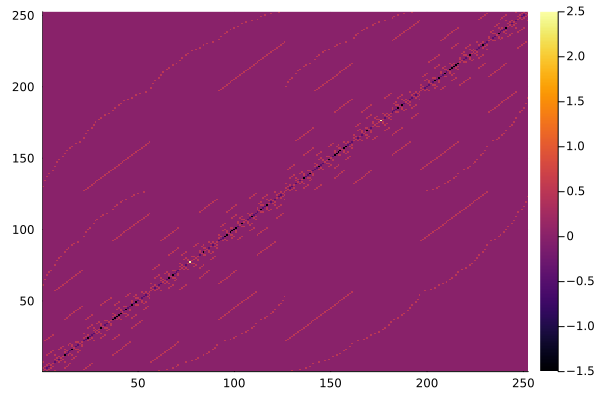

In [29]:
heatmap(H)

   Printing the Hamiltonian fo J1=1, J2=1:

In [38]:
N, Nup = 10,5
basis = FixedSzBasis(N,Nup);
J1=1
J2=1
@time H = generelized_hamiltonian_given_J1_J2_and_fixed_Sz_basis(J1,J2,basis);
@time res = eigs(H; nev=10, which=:LM, ritzvec=false) # Using Lanczos to calculate lowest eigenvalues!
En = res[1]
En_sorted=sort(res[1])

Dimension of subspace with S^z=0.0 is 252
  0.000635 seconds (34 allocations: 209.859 KiB)
  0.002138 seconds (1.38 k allocations: 105.578 KiB)


10-element Vector{Float64}:
 -5.010546278637133
 -4.395518239631329
 -4.286174614798636
 -4.286174614798609
 -4.249091694262908
 -4.212074117838646
 -4.2120741178386405
  4.118033988749893
  4.118033988749904
  5.0000000000000036

In [39]:
println("Ground state energy is ", En_sorted[1])

Ground state energy is -5.010546278637133


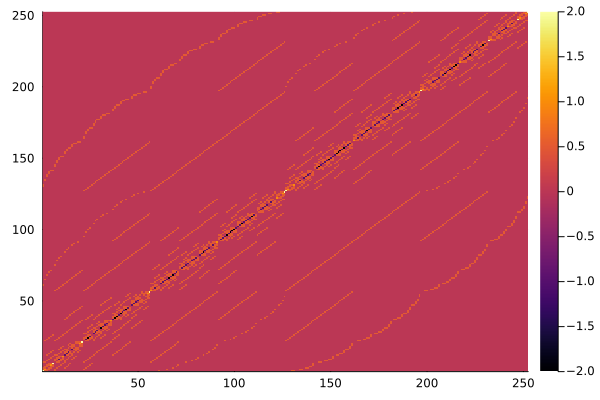

In [40]:
heatmap(H)

# (2)

In [19]:
gc=0.241
g_arr=[0, gc, 0.48 ,1/2, 1, 2, 5]
J1=1
J2_arr=g_arr.*J1

7-element Vector{Float64}:
 0.0
 0.241
 0.48
 0.5
 1.0
 2.0
 5.0

In [20]:
Ns = 6:2:18
Egs_sz0=zeros(length(Ns),length(J2_arr))
Ees_sz0=zeros(length(Ns),length(J2_arr))
Egs_sz1=zeros(length(Ns),length(J2_arr))

for (i,N) in enumerate(Ns)
    Nup = Int(N/2)
    basis_sz0 = FixedSzBasis(N,Nup);
    for (j,J2) in enumerate(J2_arr)
        @time Heff = generelized_hamiltonian_given_J1_J2_and_fixed_Sz_basis(J1,J2,basis_sz0)
        res = eigs(Heff; nev=10, which=:LM, ritzvec=false) # Using Lanczos to calculate lowest eigenvalues!
        En = sort(res[1])    
        Egs_sz0[i,j] = En[1]
        Ees_sz0[i,j] = En[2]
    end
    basis_sz1 = FixedSzBasis(N,Nup+1);
    for (j,J2) in enumerate(J2_arr)
        @time Heff = generelized_hamiltonian_given_J1_J2_and_fixed_Sz_basis(J1,J2,basis_sz1)
        res = eigs(Heff; nev=10, which=:LM, ritzvec=false) # Using Lanczos to calculate lowest eigenvalues!
        En = sort(res[1])
        Egs_sz1[i,j] = En[1]
    end
end

Dimension of subspace with S^z=0.0 is 20
  0.000024 seconds (19 allocations: 6.422 KiB)
  0.000028 seconds (25 allocations: 11.453 KiB)
  0.000025 seconds (25 allocations: 11.453 KiB)
  0.000025 seconds (25 allocations: 11.453 KiB)
  0.000024 seconds (25 allocations: 11.453 KiB)
  0.000022 seconds (25 allocations: 11.453 KiB)
  0.000021 seconds (25 allocations: 11.453 KiB)
Dimension of subspace with S^z=1.0 is 15
  0.000014 seconds (19 allocations: 5.797 KiB)
  0.000017 seconds (25 allocations: 10.578 KiB)
  0.000016 seconds (25 allocations: 10.578 KiB)
  0.000014 seconds (25 allocations: 10.578 KiB)
  0.000014 seconds (25 allocations: 10.578 KiB)
  0.000014 seconds (25 allocations: 10.578 KiB)
  0.000014 seconds (25 allocations: 10.578 KiB)
Dimension of subspace with S^z=0.0 is 70
  0.000091 seconds (21 allocations: 23.500 KiB)
  0.000149 seconds (29 allocations: 44.594 KiB)
  0.000209 seconds (29 allocations: 44.594 KiB)
  0.000129 seconds (29 allocations: 44.594 KiB)
  0.000111 seco

Checking gaplessness

g=0

In [21]:
x = 1 ./ Ns
y = Egs_sz1[:,1]-Egs_sz0[:,1]

fun(x, a) = a[1] .+ a[2]*x
res = LsqFit.curve_fit(fun, x, y, [0., 0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([0.021734853049223703, 3.9924255195646707], [0.00239745732790142, -0.0018863020977859524, -0.002261602747686442, -0.0014105340231720942, -0.00019760512171718148, 0.0010717657717253526, 0.0022868209122394456], [0.9999999999960525 0.1666666666661151; 0.9999999999960525 0.12500000000016037; … ; 0.9999999999960525 0.06250000000008019; 1.000000000000636 0.0555555555553717], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Float64[])

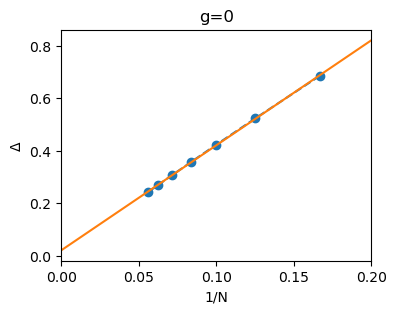

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f796e99a530>

In [22]:
figure(figsize=(4,3))
plot(x, y, "o--")
xlim(0, 0.2)
title("g=0")
xlabel("1/N")
ylabel(L"\Delta");

x1 = 0:0.001:0.2
plot(x1, fun(x1, coef(res)))

In [23]:
x = 1 ./ Ns
y = Egs_sz1[:,2]-Egs_sz0[:,2]

fun(x, a) = a[1] .+ a[2]*x
res = LsqFit.curve_fit(fun, x, y, [0., 0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([-0.009694360486076884, 3.844022401325964], [-0.0021934633458822184, 0.0019967366051708013, 0.0019043147984003639, 0.0009821887334818813, -2.2568369880737738e-5, -0.0009367378234562684, -0.0017304705754089822], [0.9999999999960525 0.1666666666660852; 1.000000000000636 0.1249999999989677; … ; 1.000000000000636 0.06249999999948385; 1.000000000000636 0.05555555555496427], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Float64[])

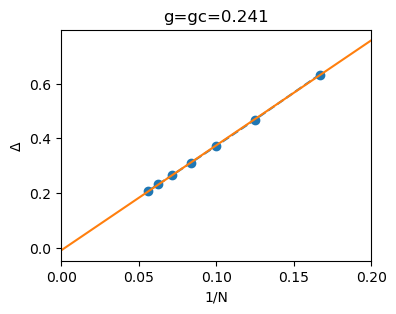

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f796e810b80>

In [24]:
figure(figsize=(4,3))
plot(x, y, "o--")
xlim(0, 0.2)
title("g=gc=0.241")
xlabel("1/N")
ylabel(L"\Delta");

x1 = 0:0.001:0.2
plot(x1, fun(x1, coef(res)))

Both g=0 and g=gc seem consistent with the gaplessness as the in large Ns the gap goes to zero (linearly)

For g>g_c, here g=0.48.

In [25]:
x = 1 ./ Ns
y = Egs_sz1[:,3]-Egs_sz0[:,3]

fun(x, a) = a[1] .+ a[2]*x .+ a[3]*(x.^2)
res = LsqFit.curve_fit(fun, x, y, [0., 0., 0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([0.1466031964703707, 1.6053601976653813, 3.624143277778763], [0.0005298400193816111, -0.0018173056855878555, 0.0006419215534361755, 0.0010159003534517819, 0.0006874611199204628, -4.7622512799438965e-5, -0.0010101948478156153], [1.0000000000052196 0.16666666667040175 0.02777777777788421; 0.9999999999960525 0.12499999999851857 0.015624999999585594; … ; 1.000000000000636 0.06250000000211445 0.003906250001161129; 1.000000000000636 0.05555555555632472 0.003086419753379297], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Float64[])

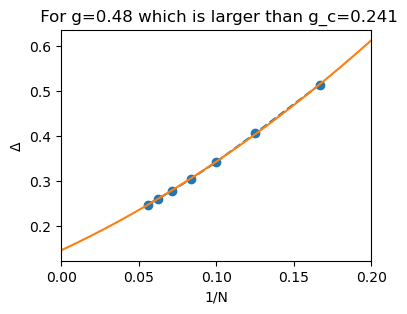

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f796e99a6b0>

In [26]:
figure(figsize=(4,3))
plot(x, y, "o--")
xlim(0, 0.2)
title(" For g=0.48 which is larger than g_c=0.241")
xlabel("1/N")
ylabel(L"\Delta");

x1 = 0:0.001:0.2
plot(x1, fun(x1, coef(res)))

In [27]:
gap_size=coef(res)[1]

0.1466031964703707

In [28]:
println("the gap size is $gap_size")

the gap size is 0.1466031964703707


For g=0.5, again larger than gc

In [29]:
x = 1 ./ Ns
y = Egs_sz1[:,4]-Egs_sz0[:,4]

fun(x, a) = a[1] .+ a[2]*x .+ a[3]*(x.^2)
res = LsqFit.curve_fit(fun, x, y, [0., 0., 0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([0.20605319946858128, 0.9756306476558062, 4.751605985759711], [0.0006473625712071218, -0.0022660885865213864, 0.000920576133168094, 0.0012192447452931687, 0.0007264616330376894, -0.00012606524149938458, -0.0011214912546926858], [1.0000000000052196 0.16666666667059232 0.02777777777702405; 1.000000000000636 0.12499999999836067 0.015625000000420084; … ; 1.000000000000636 0.06250000000147211 0.003906249999863862; 0.9999999999960525 0.05555555555991981 0.003086419753002672], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Float64[])

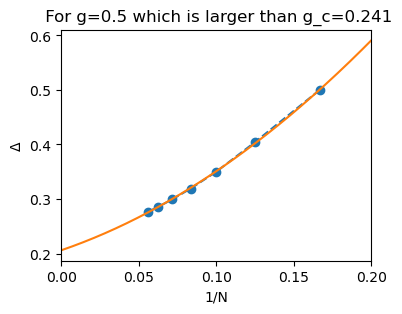

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f796e6afca0>

In [30]:
figure(figsize=(4,3))
plot(x, y, "o--")
xlim(0, 0.2)
title(" For g=0.5 which is larger than g_c=0.241")
xlabel("1/N")
ylabel(L"\Delta");

x1 = 0:0.001:0.2
plot(x1, fun(x1, coef(res)))

In [31]:
gap_size=coef(res)[1]

0.20605319946858128

In [32]:
println("the gap size is $gap_size")

the gap size is 0.20605319946858128


We can see that for the two choices of g>gc we get a good quadratic fit and the gap size (energy gap for very large N) by that fit is not zero

# (3)

In [33]:
Ns = 6:2:18
Egs_sz0=zeros(length(Ns),length(J2_arr))
Ees_sz0=zeros(length(Ns),length(J2_arr))

for (i,N) in enumerate(Ns)
    Nup = Int(N/2)
    basis_sz0 = FixedSzBasis(N,Nup);
    for (j,J2) in enumerate(J2_arr)
        @time Heff = generelized_hamiltonian_given_J1_J2_and_fixed_Sz_basis(J1,J2,basis_sz0)
        res = eigs(Heff; nev=10, which=:LM, ritzvec=false) # Using Lanczos to calculate lowest eigenvalues!
        En = sort(res[1])    
        Egs_sz0[i,j] = En[1]
        Ees_sz0[i,j] = En[2]
    end
end

Dimension of subspace with S^z=0.0 is 20
  0.000059 seconds (19 allocations: 6.422 KiB)
  0.000029 seconds (25 allocations: 11.453 KiB)
  0.000026 seconds (25 allocations: 11.453 KiB)
  0.000023 seconds (25 allocations: 11.453 KiB)
  0.000024 seconds (25 allocations: 11.453 KiB)
  0.000024 seconds (25 allocations: 11.453 KiB)
  0.000021 seconds (25 allocations: 11.453 KiB)
Dimension of subspace with S^z=0.0 is 70
  0.000102 seconds (21 allocations: 23.500 KiB)
  0.000187 seconds (29 allocations: 44.594 KiB)
  0.000118 seconds (29 allocations: 44.594 KiB)
  0.000127 seconds (29 allocations: 44.594 KiB)
  0.000131 seconds (29 allocations: 44.594 KiB)
  0.000148 seconds (29 allocations: 44.594 KiB)
  0.000129 seconds (29 allocations: 44.594 KiB)
Dimension of subspace with S^z=0.0 is 252
  0.000387 seconds (23 allocations: 76.422 KiB)
  0.000560 seconds (35 allocations: 209.891 KiB)
  0.000556 seconds (35 allocations: 209.891 KiB)
  0.000612 seconds (35 allocations: 209.891 KiB)
  0.000574

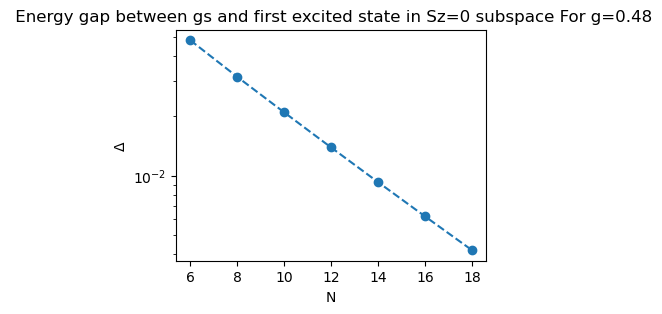

In [34]:
x =  Ns
y = Ees_sz0[:,3]-Egs_sz0[:,3]

figure(figsize=(4,3))
plot(x, y, "o--")

title(" Energy gap between gs and first excited state in Sz=0 subspace For g=0.48")
xlabel("N")
ylabel(L"\Delta");
yscale("log")


We can see here that for g=0.48>gc the gap decays exponentially as the graph is linear with a log yscale

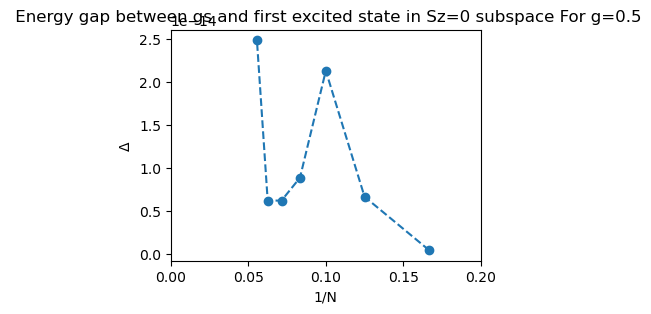

In [35]:
x = 1 ./ Ns
y = Ees_sz0[:,4]-Egs_sz0[:,4]

figure(figsize=(4,3))
plot(x, y, "o--")
xlim(0, 0.2)
title(" Energy gap between gs and first excited state in Sz=0 subspace For g=0.5")
xlabel("1/N")
ylabel(L"\Delta");

We can see that the scale of $\Delta$ is 1e-14, thus effectively zero for all N

# (4)

In this section I am calculating ψS₁S₁₊ₓψ but plotting |ψS₁S₁₊ₓψ|

In [36]:
function Sᶻⱼψ(ψ,basis,j)
    D= length(ψ)
    N_qubits= basis.N
    new_ψ=zeros(D)
    for k in range(1,length=D)
        a = basis.states[k]
        i= (j-1)%N_qubits+1
        sᵢ = ( a & 1<<(i-1) ) >> (i-1)
        new_ψ[k]=ψ[k]*(2*sᵢ-1)/2
    end
    return new_ψ
end

Sᶻⱼψ (generic function with 1 method)

In [37]:
function ψS₁S₁₊ₓψ(ψ,basis,x)
    return ψ⋅(Sᶻⱼψ(Sᶻⱼψ(ψ,basis,x+1),basis,1))
end

ψS₁S₁₊ₓψ (generic function with 1 method)

In [38]:
gc=0.241
g_arr=[0, gc, 0.48 ,1/2, 1, 2, 5]
J1=1
J2_arr=g_arr.*J1
N=18

18

In [39]:
Nup = Int(N/2)
basis_sz0 = FixedSzBasis(N,Nup);
ground_states_arr=Array{Vector{Any}}(undef,length(J2_arr))

Dimension of subspace with S^z=0.0 is 48620


7-element Vector{Vector{Any}}:
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef

In [40]:
for (i,J2) in enumerate(J2_arr)
    @time Heff = generelized_hamiltonian_given_J1_J2_and_fixed_Sz_basis(J1,J2,basis_sz0)
    eigenvalues, eigenvectors = eigs(Heff; nev=1, which=:LM, ritzvec=true) # Using Lanczos to calculate lowest eigenvalues!
    ground_states_arr[i]=eigenvectors[:,1]
end

 10.106726 seconds (41 allocations: 28.488 MiB, 0.11% gc time)
 24.557672 seconds (65 allocations: 46.754 MiB, 0.03% gc time)
 23.635220 seconds (65 allocations: 46.754 MiB, 0.63% gc time)
 23.291354 seconds (65 allocations: 46.754 MiB, 0.01% gc time)
 23.133349 seconds (65 allocations: 46.754 MiB, 0.01% gc time)
 22.886925 seconds (65 allocations: 46.754 MiB, 0.02% gc time)
 23.437216 seconds (65 allocations: 46.754 MiB, 0.01% gc time)


g=0

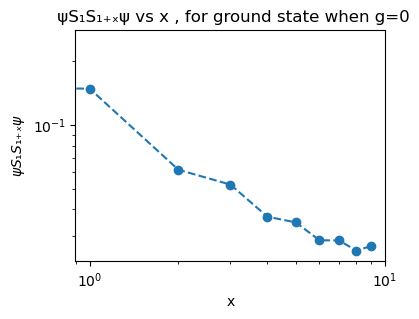

In [78]:
x = range(0,9)
y = [abs(ψS₁S₁₊ₓψ(ground_states_arr[1],basis_sz0,i)) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ψS₁S₁₊ₓψ vs x , for ground state when g=0")
xlabel("x")
ylabel(L"ψS₁S₁₊ₓψ");
xscale("log")
yscale("log")

g=g_c=0.241

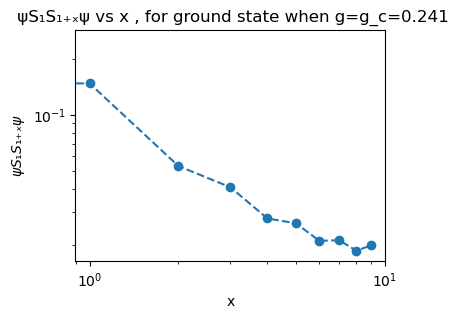

In [79]:
x = range(0,9)
y = [abs(ψS₁S₁₊ₓψ(ground_states_arr[2],basis_sz0,i)) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ψS₁S₁₊ₓψ vs x , for ground state when g=g_c=0.241")
xlabel("x")
ylabel(L"ψS₁S₁₊ₓψ");
xscale("log")
yscale("log")

g=0.48

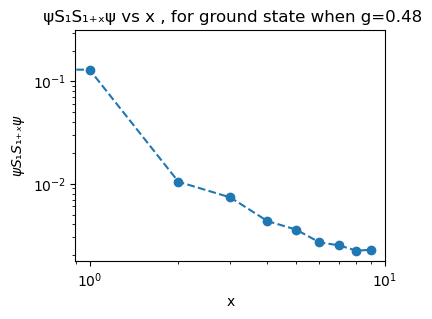

In [80]:
x = range(0,9)
y = [abs(ψS₁S₁₊ₓψ(ground_states_arr[3],basis_sz0,i)) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ψS₁S₁₊ₓψ vs x , for ground state when g=0.48")
xlabel("x")
ylabel(L"ψS₁S₁₊ₓψ");
xscale("log")
yscale("log")

g=0.5

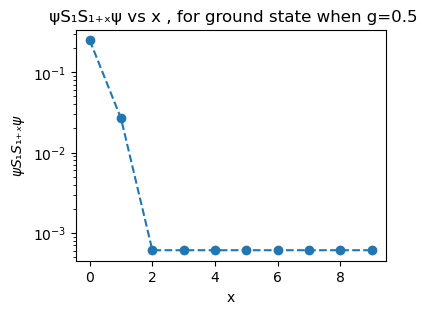

In [85]:
x = range(0,9)
y = [abs(ψS₁S₁₊ₓψ(ground_states_arr[4],basis_sz0,i)) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ψS₁S₁₊ₓψ vs x , for ground state when g=0.5")
xlabel("x")
ylabel(L"ψS₁S₁₊ₓψ");
yscale("log")

g=1

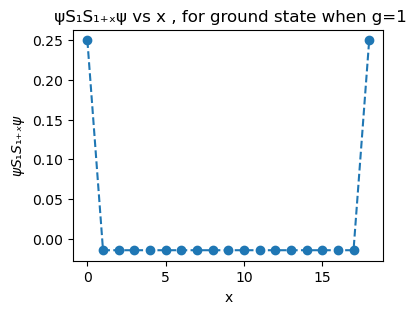

In [82]:
x = range(0,18)
y = [ψS₁S₁₊ₓψ(ground_states_arr[5],basis_sz0,i) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ψS₁S₁₊ₓψ vs x , for ground state when g=1")
xlabel("x")
ylabel(L"ψS₁S₁₊ₓψ");

g=2

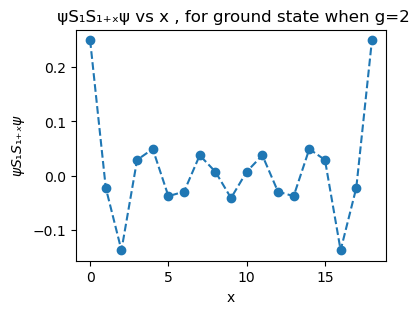

In [46]:
x = range(0,18)
y = [ψS₁S₁₊ₓψ(ground_states_arr[6],basis_sz0,i) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ψS₁S₁₊ₓψ vs x , for ground state when g=2")
xlabel("x")
ylabel(L"ψS₁S₁₊ₓψ");

g=5

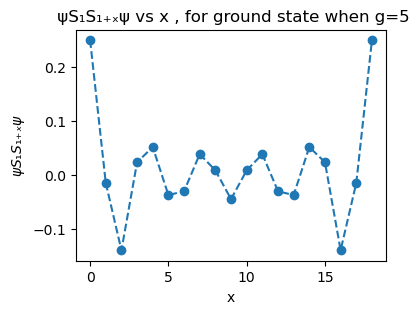

In [47]:
x = range(0,18)
y = [ψS₁S₁₊ₓψ(ground_states_arr[7],basis_sz0,i) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ψS₁S₁₊ₓψ vs x , for ground state when g=5")
xlabel("x")
ylabel(L"ψS₁S₁₊ₓψ");

I am not sure about how to interpret the results of g larger than g_c, it seems the decay is even stronger an exponantial.

# (5)

In [90]:
function Bₓ(ψ,basis,x)
    return Sᶻⱼψ(Sᶻⱼψ(ψ,basis,x+1),basis,x)
end

Bₓ (generic function with 1 method)

In [91]:
function B₁Bₓ₊₁(ψ,basis,x)
    return Bₓ(Bₓ(ψ,basis,1+x),basis,1)
end

B₁Bₓ₊₁ (generic function with 1 method)

g=0

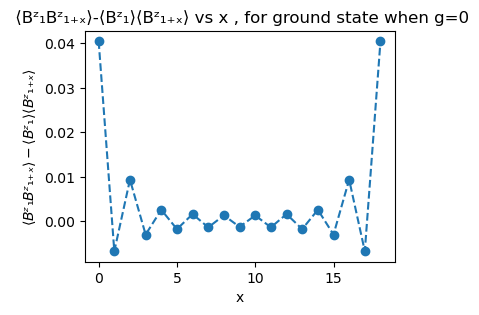

In [92]:
x = range(0,18)
ψ=ground_states_arr[1]
y = [ψ⋅B₁Bₓ₊₁(ψ,basis_sz0,i)- (ψ⋅Bₓ(ψ,basis_sz0,1))*(ψ⋅Bₓ(ψ,basis_sz0,1+i)) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩ vs x , for ground state when g=0")
xlabel("x")
ylabel(L"⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩");

g=0.241

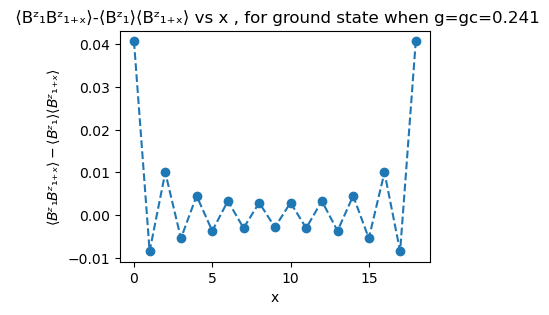

In [93]:
x = range(0,18)
ψ=ground_states_arr[2]
y = [ψ⋅B₁Bₓ₊₁(ψ,basis_sz0,i)- (ψ⋅Bₓ(ψ,basis_sz0,1))*(ψ⋅Bₓ(ψ,basis_sz0,1+i)) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩ vs x , for ground state when g=gc=0.241")
xlabel("x")
ylabel(L"⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩");

The value of the absolute value of the quantity for g<=gc keeps decaying to 0 as x gets larger, untill the middle of the chain, as the problem is symmetric and than grows again.

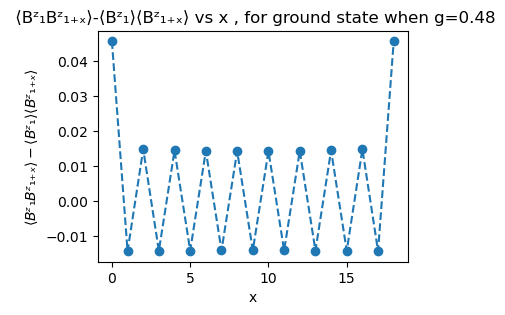

In [94]:
x = range(0,18)
ψ=ground_states_arr[3]
y = [ψ⋅B₁Bₓ₊₁(ψ,basis_sz0,i)- (ψ⋅Bₓ(ψ,basis_sz0,1))*(ψ⋅Bₓ(ψ,basis_sz0,1+i)) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩ vs x , for ground state when g=0.48")
xlabel("x")
ylabel(L"⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩");

Here it is clear the value does seem to saturate (up to plusminus sign) around a value of 0.015

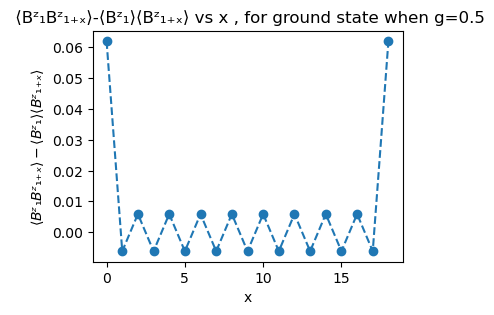

In [53]:
x = range(0,18)
ψ=ground_states_arr[4]
y = [ψ⋅B₁Bₓ₊₁(ψ,basis_sz0,i)- (ψ⋅Bₓ(ψ,basis_sz0,1))*(ψ⋅Bₓ(ψ,basis_sz0,1+i)) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩ vs x , for ground state when g=0.5")
xlabel("x")
ylabel(L"⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩");

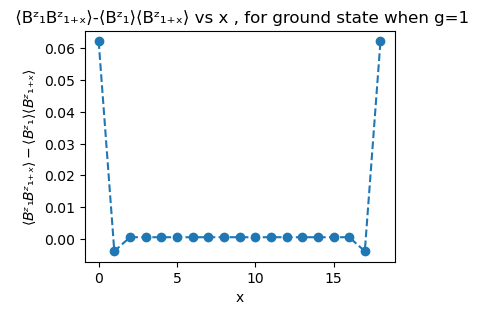

In [54]:
x = range(0,18)
ψ=ground_states_arr[5]
y = [ψ⋅B₁Bₓ₊₁(ψ,basis_sz0,i)- (ψ⋅Bₓ(ψ,basis_sz0,1))*(ψ⋅Bₓ(ψ,basis_sz0,1+i)) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩ vs x , for ground state when g=1")
xlabel("x")
ylabel(L"⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩");